In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (8, 5)
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import boxcox
from sklearn.feature_selection import chi2, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv(filepath_or_buffer='train.csv')
test_df = pd.read_csv(filepath_or_buffer='test.csv')

test_loan_id = test_df['Loan_ID']

# EDA (Exploriatory Data Analysis)

In [3]:
train_df.shape

(614, 13)

In [4]:
test_df.shape

(367, 12)

In [5]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [6]:
test_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [7]:
# <-- Drop 'Loan_ID' -->

train_df.drop(labels='Loan_ID',  axis=1, inplace=True)
test_df.drop(labels='Loan_ID',  axis=1, inplace=True)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


In [9]:
train_df['Credit_History'].replace({1:'Good', 0:'Bad'}, inplace=True)
test_df['Credit_History'].replace({1:'Good', 0:'Bad'}, inplace=True)

In [10]:
continuous_features = ['Loan_Amount_Term', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
categorical_features = ['Dependents', 'Gender', 'Married', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status']

In [11]:
pd.set_option('display.max_rows', 100)

temp_df = ...

def custom_table(df):
    column_names = df.columns
    types = [df[column].dtype for column in column_names]
    total_count = [df[column].count() for column in column_names]
    distincts = [len(df[column].unique()) for column in column_names]
    uniques = [df[column].unique() for column in column_names]
    null_count = [df[column].isnull().sum() for column in column_names]
    null_percentage = [round((n_c/1460)*100, 2) for n_c in null_count]
    skewness =  [df[column].skew() if column in continuous_features else np.nan for column in column_names ]
    feature_type = ['continuous' if column in continuous_features else 'categorical' for column in column_names]


    data = zip(types, total_count, distincts, uniques,null_count, null_percentage, skewness,feature_type)

    temp_df = pd.DataFrame(data=data, columns=['types', 'total_count', 'distincts', 'uniques','null_count', 
                                               'null_percentage', 'skewness','feature_type'], index=column_names)
    
    return temp_df

In [12]:
custom_table(train_df)

,types,total_count,distincts,uniques,null_count,null_percentage,skewness,feature_type
Gender,object,601,3,"[Male, Female, nan]",13,0.89,NaN,categorical
Married,object,611,3,"[No, Yes, nan]",3,0.21,NaN,categorical
Dependents,object,599,5,"[0, 1, 2, 3+, nan]",15,1.03,NaN,categorical
Education,object,614,2,"[Graduate, Not Graduate]",0,0.00,NaN,categorical
Self_Employed,object,582,3,"[No, Yes, nan]",32,2.19,NaN,categorical
ApplicantIncome,int64,614,505,"[5849, 4583, 3000, 2583, 6000, 5417, 2333, 303...",0,0.00,6.539513,continuous
CoapplicantIncome,float64,614,287,"[0.0, 1508.0, 2358.0, 4196.0, 1516.0, 2504.0, ...",0,0.00,7.491531,continuous
LoanAmount,float64,592,204,"[nan, 128.0, 66.0, 120.0, 141.0, 267.0, 95.0, ...",22,1.51,2.677552,continuous
Loan_Amount_Term,float64,600,11,"[360.0, 120.0, 240.0, nan, 180.0, 60.0, 300.0,...",14,0.96,-2.362414,continuous
Credit_History,object,564,3,"[Good, Bad, nan]",50,3.42,NaN,categorical


## Imputing for categorical variables

In [13]:
# <<--- Gender --->>

train_df['Gender'] = train_df['Gender'].fillna(train_df['Gender'].mode()[0]) 
test_df['Gender'] = test_df['Gender'].fillna(test_df['Gender'].mode()[0])

In [14]:
# <<--- Married --->>

train_df['Married'] = train_df['Married'].fillna(train_df['Married'].mode()[0]) 
test_df['Married'] = test_df['Married'].fillna(test_df['Married'].mode()[0]) 

In [15]:
# <<--- Dependents --->>

train_df['Dependents'] = train_df['Dependents'].fillna(train_df['Dependents'].mode()[0]) 
test_df['Dependents'] = test_df['Dependents'].fillna(test_df['Dependents'].mode()[0]) 

In [16]:
# <<--- Self_Employed --->>

train_df['Self_Employed'] = train_df['Self_Employed'].fillna(train_df['Self_Employed'].mode()[0]) 
test_df['Self_Employed'] = test_df['Self_Employed'].fillna(test_df['Self_Employed'].mode()[0]) 

In [17]:
# <<--- Credit_History --->>

train_df['Credit_History'] = train_df['Credit_History'].fillna(train_df['Credit_History'].mode()[0]) 
test_df['Credit_History'] = test_df['Credit_History'].fillna(test_df['Credit_History'].mode()[0]) 

## Imputing for continuous variables

In [18]:
# <<--- LoanAmount --->>

train_df['LoanAmount'] = train_df['LoanAmount'].fillna(train_df['LoanAmount'].median())
test_df['LoanAmount'] = test_df['LoanAmount'].fillna(test_df['LoanAmount'].median())

In [19]:
# <<--- Loan_Amount_Term --->>

train_df['Loan_Amount_Term'] = train_df['Loan_Amount_Term'].fillna(train_df['Loan_Amount_Term'].median())
test_df['Loan_Amount_Term'] = test_df['Loan_Amount_Term'].fillna(test_df['Loan_Amount_Term'].median())

In [20]:
custom_table(train_df)

,types,total_count,distincts,uniques,null_count,null_percentage,skewness,feature_type
Gender,object,614,2,"[Male, Female]",0,0.0,NaN,categorical
Married,object,614,2,"[No, Yes]",0,0.0,NaN,categorical
Dependents,object,614,4,"[0, 1, 2, 3+]",0,0.0,NaN,categorical
Education,object,614,2,"[Graduate, Not Graduate]",0,0.0,NaN,categorical
Self_Employed,object,614,2,"[No, Yes]",0,0.0,NaN,categorical
ApplicantIncome,int64,614,505,"[5849, 4583, 3000, 2583, 6000, 5417, 2333, 303...",0,0.0,6.539513,continuous
CoapplicantIncome,float64,614,287,"[0.0, 1508.0, 2358.0, 4196.0, 1516.0, 2504.0, ...",0,0.0,7.491531,continuous
LoanAmount,float64,614,203,"[128.0, 66.0, 120.0, 141.0, 267.0, 95.0, 158.0...",0,0.0,2.743053,continuous
Loan_Amount_Term,float64,614,10,"[360.0, 120.0, 240.0, 180.0, 60.0, 300.0, 480....",0,0.0,-2.402112,continuous
Credit_History,object,614,2,"[Good, Bad]",0,0.0,NaN,categorical


In [21]:
custom_table(test_df)

,types,total_count,distincts,uniques,null_count,null_percentage,skewness,feature_type
Gender,object,367,2,"[Male, Female]",0,0.0,NaN,categorical
Married,object,367,2,"[Yes, No]",0,0.0,NaN,categorical
Dependents,object,367,4,"[0, 1, 2, 3+]",0,0.0,NaN,categorical
Education,object,367,2,"[Graduate, Not Graduate]",0,0.0,NaN,categorical
Self_Employed,object,367,2,"[No, Yes]",0,0.0,NaN,categorical
ApplicantIncome,int64,367,314,"[5720, 3076, 5000, 2340, 3276, 2165, 2226, 388...",0,0.0,8.441375,continuous
CoapplicantIncome,int64,367,194,"[0, 1500, 1800, 2546, 3422, 2400, 1516, 2916, ...",0,0.0,4.257357,continuous
LoanAmount,float64,367,144,"[110.0, 126.0, 208.0, 100.0, 78.0, 152.0, 59.0...",0,0.0,2.244601,continuous
Loan_Amount_Term,float64,367,12,"[360.0, 240.0, 180.0, 60.0, 480.0, 84.0, 12.0,...",0,0.0,-2.709537,continuous
Credit_History,object,367,2,"[Good, Bad]",0,0.0,NaN,categorical


In [22]:
temp_train_df = train_df.copy()

In [23]:
temp_train_df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,Good,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,Good,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,Good,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,Good,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,Good,Urban,Y


# Categorical Variables

In [24]:
# <-- Label Encode Categorical Variables -->

for column in categorical_features:
    l = LabelEncoder()
    temp_train_df[column] = l.fit_transform(temp_train_df[column])

In [25]:
temp_train_df = temp_train_df[categorical_features]

In [26]:
new_categorical_features = categorical_features[:-1]
seen = list()

for feature in new_categorical_features:
    try:
        x_features = [i for i in new_categorical_features if i != feature and i not in seen]
        X = temp_train_df[x_features]

        Y = temp_train_df[feature] # Dependent Feature

        chi_scores, p_values = chi2(X=X, y=Y)

        p_values = pd.Series(p_values,index = X.columns)

        print()
        print(f"For <<-- {feature} -->")
        print(p_values)

        for j in range (0, len(p_values)):
            if (p_values[j] < 0.05):
                print(p_values[j])

        seen.append(feature)
    except ValueError:
        pass


For <<-- Dependents -->
Gender            0.313629
Married           0.000005
Education         0.602805
Self_Employed     0.159554
Credit_History    0.955121
Property_Area     0.286656
dtype: float64
4.627292749169103e-06

For <<-- Gender -->
Married           1.033668e-07
Education         3.202845e-01
Self_Employed     9.903387e-01
Credit_History    9.310624e-01
Property_Area     6.220571e-01
dtype: float64
1.0336676344223253e-07

For <<-- Married -->
Education         0.787487
Self_Employed     0.917539
Credit_History    0.917812
Property_Area     0.935061
dtype: float64

For <<-- Education -->
Self_Employed     0.810728
Credit_History    0.487127
Property_Area     0.211708
dtype: float64

For <<-- Self_Employed -->
Credit_History    0.988330
Property_Area     0.554704
dtype: float64

For <<-- Credit_History -->
Property_Area    0.970026
dtype: float64


In [27]:
# Drop 'Dependents' and 'Gender' as they both are dependent on 'Marrige'

train_df.drop(labels=['Dependents', 'Gender'], axis=1, inplace=True)
test_df.drop(labels=['Dependents', 'Gender'], axis=1, inplace=True)

# Continuous Variables

## Correlation Marix

In [28]:
corr_matrix = train_df.corr()

(4.0, 0.0)

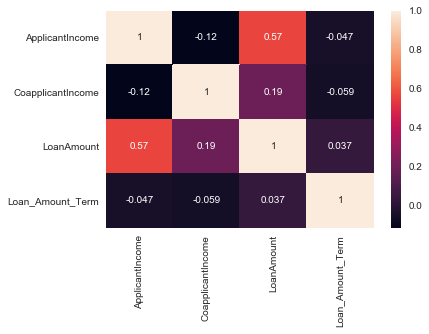

In [29]:
# Heatmap of corelation matrix
ax = sns.heatmap(data=corr_matrix, annot=True)

# below two lines are just to put the heat map or matrix properly 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

## Pair Plot

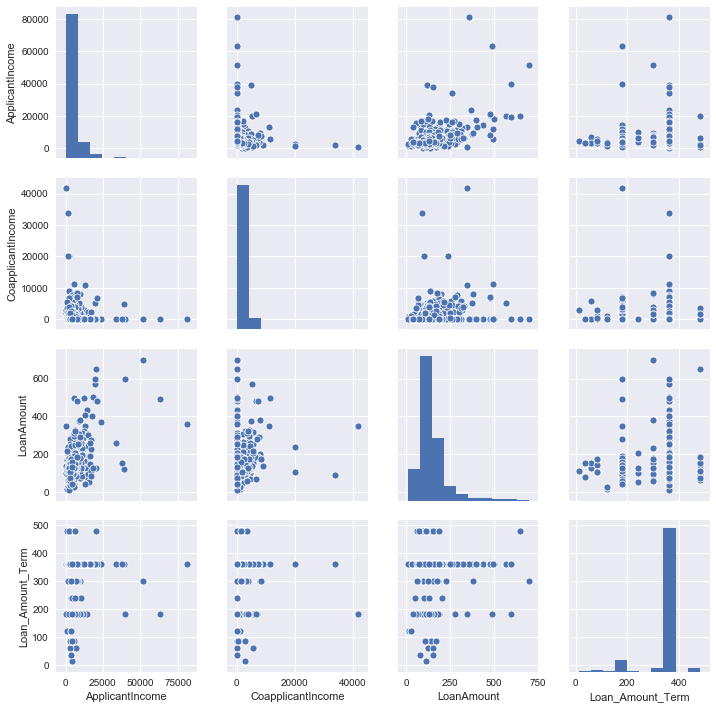

In [30]:
# Train

sns.pairplot(train_df)

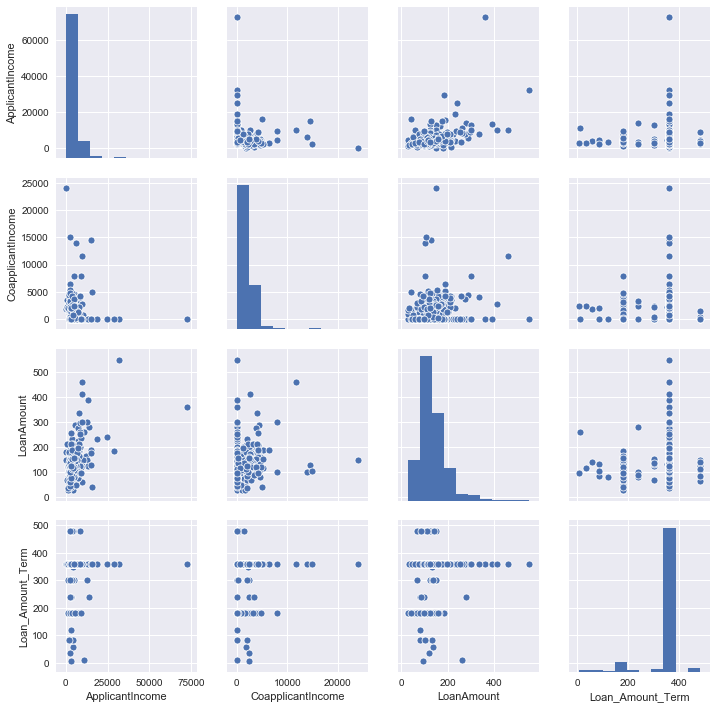

In [31]:
# Test

sns.pairplot(test_df)

## Outliars Check 

In [32]:
# <<-- ApplicantIncome -->>

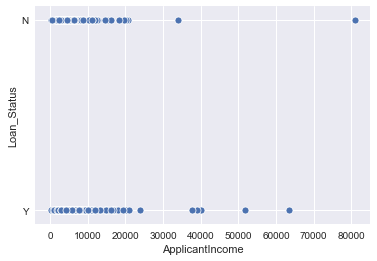

In [33]:
sns.scatterplot(x=train_df['ApplicantIncome'], y=train_df['Loan_Status'], palette='s')

In [34]:
train_df[train_df['ApplicantIncome'] > 40000]

,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
171,Yes,Graduate,No,51763,0.0,700.0,300.0,Good,Urban,Y
333,Yes,Graduate,No,63337,0.0,490.0,180.0,Good,Urban,Y
409,Yes,Graduate,No,81000,0.0,360.0,360.0,Bad,Rural,N


In [35]:
mask = (train_df['ApplicantIncome'] > 40000)
train_df = train_df[~mask]

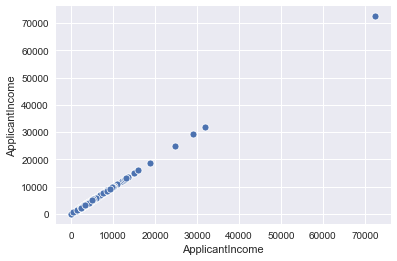

In [36]:
sns.scatterplot(x=test_df['ApplicantIncome'], y=test_df['ApplicantIncome'])

In [37]:
test_df[test_df['ApplicantIncome'] > 40000]

,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
81,Yes,Graduate,No,72529,0,360.0,360.0,Good,Urban


Skewness:  3.8683494203272786
Skewness:  8.441374954190996


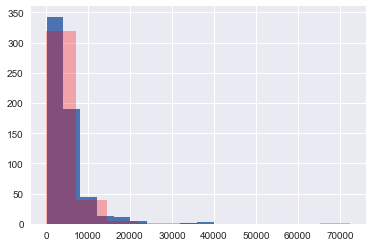

In [38]:
train_df['ApplicantIncome'].hist()
print('Skewness: ', train_df['ApplicantIncome'].skew())

test_df['ApplicantIncome'].hist(alpha=0.3, color='red')
print('Skewness: ', test_df['ApplicantIncome'].skew())

In [39]:
# train_df['ApplicantIncome'].replace({0:0.1}, inplace=True)
# test_df['ApplicantIncome'].replace({0:0.1}, inplace=True)

In [40]:
# BoxCox 'ApplicantIncome'

# box_cox_ApplicantIncome_train = boxcox(x=train_df['ApplicantIncome'])[0]
# sns.distplot(box_cox_ApplicantIncome_train)
# print('Skewness: ', pd.Series(box_cox_ApplicantIncome_train).skew())

# box_cox_ApplicantIncome_test = boxcox(x=test_df['ApplicantIncome'])[0]
# sns.distplot(box_cox_ApplicantIncome_test)
# print('Skewness: ', pd.Series(box_cox_ApplicantIncome_test).skew())

In [41]:
# train_df['ApplicantIncome'] = box_cox_ApplicantIncome_train
# test_df['ApplicantIncome'] = box_cox_ApplicantIncome_test

In [42]:
# <<-- CoApplicantIncome -->>

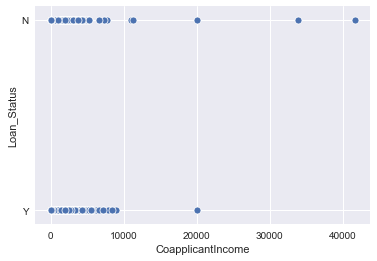

In [43]:
sns.scatterplot(x=train_df['CoapplicantIncome'], y=train_df['Loan_Status'], palette='s')

In [44]:
train_df[train_df['CoapplicantIncome'] > 20000]

,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
581,No,Graduate,No,1836,33837.0,90.0,360.0,Good,Urban,N
600,No,Graduate,No,416,41667.0,350.0,180.0,Good,Urban,N


In [45]:
# Drop above 2 rows

train_df.drop(labels=[581, 600], axis=0, inplace=True)

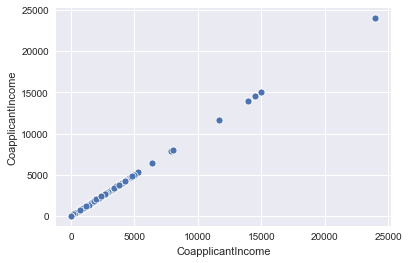

In [46]:
sns.scatterplot(x=test_df['CoapplicantIncome'], y=test_df['CoapplicantIncome'], palette='s')

In [47]:
test_df[test_df['CoapplicantIncome'] > 20000]

,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
25,No,Graduate,No,0,24000,148.0,360.0,Bad,Rural


Skewness:  7.482912597869652
Skewness:  4.257356934477602


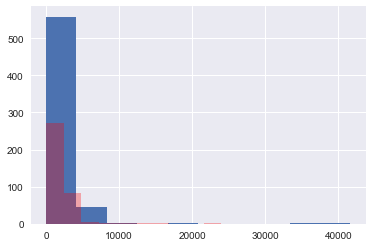

In [48]:
train_df['CoapplicantIncome'].hist()
print('Skewness: ', train_df['CoapplicantIncome'].skew())

test_df['CoapplicantIncome'].hist(alpha=0.3, color='red')
print('Skewness: ', test_df['CoapplicantIncome'].skew())

In [49]:
# train_df['CoapplicantIncome'].replace({0:0.1}, inplace=True)
# test_df['CoapplicantIncome'].replace({0:0.1}, inplace=True)

In [50]:
# BoxCox 'CoapplicantIncome'

# box_cox_CoapplicantIncome_train = boxcox(x=train_df['CoapplicantIncome'])[0]
# sns.distplot(box_cox_CoapplicantIncome_train)
# print('Skewness: ', pd.Series(box_cox_CoapplicantIncome_train).skew())

# box_cox_CoapplicantIncome_test = boxcox(x=test_df['CoapplicantIncome'])[0]
# sns.distplot(box_cox_CoapplicantIncome_test)
# print('Skewness: ', pd.Series(box_cox_CoapplicantIncome_test).skew())

In [51]:
# train_df['CoapplicantIncome'] = box_cox_CoapplicantIncome_train
# test_df['CoapplicantIncome'] = box_cox_CoapplicantIncome_test

In [52]:
# <-- LoanAmount --> 

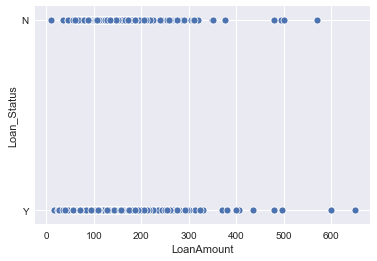

In [53]:
sns.scatterplot(x=train_df['LoanAmount'], y=train_df['Loan_Status'], palette='s')

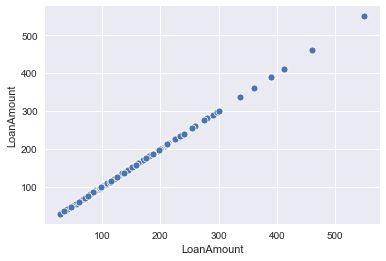

In [54]:
sns.scatterplot(x=test_df['LoanAmount'], y=test_df['LoanAmount'], palette='s')

In [55]:
train_df[train_df['LoanAmount'] > 500]

,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
130,No,Graduate,Yes,20166,0.0,650.0,480.0,Good,Urban,Y
155,Yes,Graduate,No,39999,0.0,600.0,180.0,Bad,Semiurban,Y
369,Yes,Graduate,No,19730,5266.0,570.0,360.0,Good,Rural,N
561,Yes,Graduate,Yes,19484,0.0,600.0,360.0,Good,Semiurban,Y


In [56]:
test_df[test_df['LoanAmount'] > 500]

,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
143,Yes,Graduate,Yes,32000,0,550.0,360.0,Good,Semiurban


Skewness:  2.6026998587440104
Skewness:  2.244600521260248


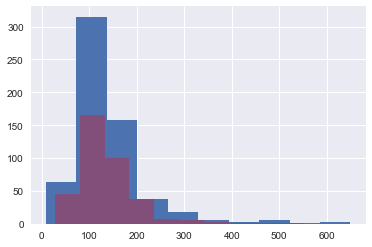

In [57]:
train_df['LoanAmount'].hist()
print('Skewness: ', train_df['LoanAmount'].skew())

test_df['LoanAmount'].hist(alpha=0.3, color='red')
print('Skewness: ', test_df['LoanAmount'].skew())

In [58]:
# BoxCox 'LoanAmount'

# box_cox_LoanAmount_train = boxcox(x=train_df['LoanAmount'])[0]
# sns.distplot(box_cox_LoanAmount_train)
# print('Skewness: ', pd.Series(box_cox_LoanAmount_train).skew())

# box_cox_LoanAmount_test = boxcox(x=test_df['LoanAmount'])[0]
# sns.distplot(box_cox_LoanAmount_test)
# print('Skewness: ', pd.Series(box_cox_LoanAmount_test).skew())

In [59]:
# train_df['LoanAmount'] = box_cox_LoanAmount_train
# test_df['LoanAmount'] = box_cox_LoanAmount_test

In [60]:
# <-- f test -->

In [61]:
temp_train_df = train_df[continuous_features]

In [62]:
le = LabelEncoder()
Y = le.fit_transform(train_df['Loan_Status'])

In [63]:
new_continuous_features = continuous_features
seen = list()

for feature in new_continuous_features:
    try:
        x_features = [i for i in new_continuous_features if i != feature and i not in seen]
        X = temp_train_df[x_features]

        Y = temp_train_df[feature] # Dependent Feature

        chi_scores, p_values = f_classif(X=X, y=Y)

        p_values = pd.Series(p_values,index = X.columns)

        print()
        print(f"For <<-- {feature} -->")
        print(p_values)

        for j in range (0, len(p_values)):
            if (p_values[j] < 0.05):
                print(p_values[j])

        seen.append(feature)
    except ValueError:
        pass


For <<-- Loan_Amount_Term -->
ApplicantIncome      0.976395
CoapplicantIncome    0.367127
LoanAmount           0.503293
dtype: float64

For <<-- ApplicantIncome -->
CoapplicantIncome    0.010031
LoanAmount           0.000005
dtype: float64
0.010030837499440472
4.528299766106924e-06

For <<-- CoapplicantIncome -->
LoanAmount    0.998094
dtype: float64


In [64]:
# Drop 'LoanAmount' as it is correlated with 'ApplicantIncome' and 'Loan_Amount_Term'
 
train_df.drop(labels= 'LoanAmount', axis=1, inplace=True)
test_df.drop(labels= 'LoanAmount', axis=1, inplace=True)

continuous_features.remove('LoanAmount')

In [65]:
train_df.describe()

,ApplicantIncome,CoapplicantIncome,Loan_Amount_Term
count,611.000000,611.000000,611.000000
mean,5109.040917,1629.206088,342.716858
std,4361.549063,2931.220236,64.223611
min,150.000000,0.000000,12.000000
25%,2875.500000,0.000000,360.000000
50%,3800.000000,1213.000000,360.000000
75%,5746.000000,2304.000000,360.000000
max,39999.000000,41667.000000,480.000000


In [66]:
test_df.describe()

,ApplicantIncome,CoapplicantIncome,Loan_Amount_Term
count,367.000000,367.000000,367.000000
mean,4805.599455,1569.577657,342.822888
std,4910.685399,2334.232099,64.658402
min,0.000000,0.000000,6.000000
25%,2864.000000,0.000000,360.000000
50%,3786.000000,1025.000000,360.000000
75%,5060.000000,2430.500000,360.000000
max,72529.000000,24000.000000,480.000000


## Scale Continuous Data (for KNN and SVM)

In [67]:
temp_train = train_df.copy()
temp_test = test_df.copy()

In [68]:
ss = StandardScaler()

ss.fit(temp_train[continuous_features])
temp_train[continuous_features] = ss.transform(temp_train[continuous_features])
temp_test[continuous_features] = ss.transform(temp_test[continuous_features])

In [69]:
temp_train.head()

,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,No,Graduate,No,0.169794,-0.556267,0.269329,Good,Urban,Y
1,Yes,Graduate,No,-0.120708,-0.041384,0.269329,Good,Rural,N
2,Yes,Graduate,Yes,-0.483949,-0.556267,0.269329,Good,Urban,Y
3,Yes,Not Graduate,No,-0.579636,0.248835,0.269329,Good,Urban,Y
4,No,Graduate,No,0.204443,-0.556267,0.269329,Good,Urban,Y


In [70]:
temp_test.head()

,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,Loan_Amount_Term,Credit_History,Property_Area
0,Yes,Graduate,No,0.140193,-0.556267,0.269329,Good,Urban
1,Yes,Graduate,No,-0.466510,-0.044115,0.269329,Good,Urban
2,Yes,Graduate,No,-0.025021,0.058315,0.269329,Good,Urban
3,Yes,Graduate,No,-0.635396,0.313025,0.269329,Good,Urban
4,No,Not Graduate,No,-0.420617,-0.556267,0.269329,Good,Urban


## Encode categorical variables

In [71]:
train_df = pd.get_dummies(data=train_df, drop_first=True)
test_df = pd.get_dummies(data=test_df, drop_first=True)

temp_train = pd.get_dummies(data=temp_train, drop_first=True)
temp_test = pd.get_dummies(data=temp_test, drop_first=True)

In [72]:
print(train_df.shape)
print(temp_train.shape)

(611, 10)
(611, 10)


In [73]:
print(test_df.shape)
print(temp_test.shape)

(367, 9)
(367, 9)


## Independent and Dependent variables

In [74]:
X = train_df.iloc[:, :-1]
Y = train_df['Loan_Status_Y']

temp_train_X = temp_train.iloc[:, :-1]
temp_train_Y = temp_train['Loan_Status_Y']

In [75]:
print(X.shape)
print(temp_train_X.shape)

(611, 9)
(611, 9)


In [76]:
print(test_df.shape)
print(temp_test.shape)

(367, 9)
(367, 9)


# Model Making

## 1. Logistic Regression

In [77]:
logistic = LogisticRegression()
logistic.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [78]:
# <<--- K fold cross validation --->> Before Parameter Tuning
accuracies = cross_val_score(estimator = logistic, scoring='accuracy', X = X, y = Y, cv = 5) 

print("Average Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average Accuracy: 80.69 %
Standard Deviation: 2.78 %


In [79]:
parameters = { 'penalty' : ['l1', 'l2'],
                'C' : np.logspace(-4, 4, 20),
                'solver' : ['liblinear', 'warn']
                }

In [80]:
# <<-- Check the best Logistic Regression Model by parameter tuning -->>

random_search = RandomizedSearchCV(estimator = logistic,
                           param_distributions  = parameters,
                           scoring = 'accuracy', 
                           cv = 5,
                           n_jobs=1)

random_search = random_search.fit(X, Y)

best_accuracy = random_search.best_score_   
best_parameters = random_search.best_params_  

print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 80.85 %
Best Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.23357214690901212}


In [82]:
final_logistic = LogisticRegression(solver= 'liblinear', penalty= 'l1', C=0.23357214690901212)

In [83]:
# <<--- K fold cross validation --->> After Parameter Tuning
accuracies = cross_val_score(estimator = final_logistic, scoring='accuracy', X = X, y = Y, cv = 5) 

print("Average Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average Accuracy: 80.85 %
Standard Deviation: 3.31 %


## 2. KNN

Text(0.5, 1.0, 'Elbow plot')

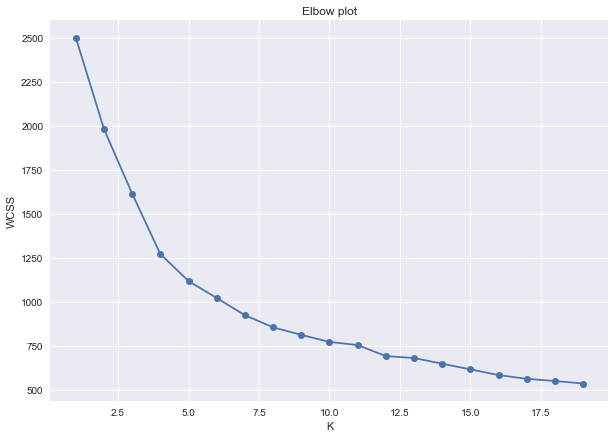

In [84]:
wcss = []  # list of wcss of kmeans model from k 1 to 10
K = []  # list of k (number of clusters) of kmeans model from k 1 to 10

for k in range(0, 20):  # here we will make 10 clusters from 1 to 10
    try:
        kmeans = KMeans(n_clusters=k, init='k-means++') 
        kmeans.fit(temp_train_X)  

        K.append(k)
        wcss.append(kmeans.inertia_)  # kmeans.inertia_ returns us the wcss value

    except OverflowError:  
        continue

plt.figure(figsize=(10, 7))  
        
plt.plot(K, wcss, marker='o')
plt.xlabel('K')
plt.ylabel('WCSS')
plt.title('Elbow plot')

In [85]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(temp_train_X, temp_train_Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [86]:
# <<--- K fold cross validation --->> Before Parameter Tuning
accuracies = cross_val_score(estimator = knn_classifier, scoring='accuracy', X = temp_train_X, y = temp_train_Y, cv = 5) 

print("Average Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average Accuracy: 78.39 %
Standard Deviation: 4.45 %


In [87]:
parameters = { 'n_neighbors':list(range(1, 20, 1)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': list(range(10, 100, 10))
                }

In [88]:
# <<-- Check the best KNN Model by parameter tuning -->>

random_search = RandomizedSearchCV(estimator = knn_classifier,
                           param_distributions = parameters,
                           scoring = 'accuracy', 
                           cv = 5,
                           n_jobs=1)

random_search = random_search.fit(temp_train_X, temp_train_Y)

best_accuracy = random_search.best_score_   
best_parameters = random_search.best_params_  

print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 78.07 %
Best Parameters: {'weights': 'uniform', 'n_neighbors': 12, 'leaf_size': 40, 'algorithm': 'kd_tree'}


In [89]:
final_knn_classifier = KNeighborsClassifier(weights= 'uniform', n_neighbors= 12, leaf_size= 40, algorithm= 'kd_tree')

In [90]:
# <<--- K fold cross validation --->> Before Parameter Tuning
accuracies = cross_val_score(estimator = final_knn_classifier, scoring='accuracy', X = temp_train_X, y = temp_train_Y, cv = 5) 

print("Average Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average Accuracy: 78.06 %
Standard Deviation: 3.85 %


## 3. SVM

In [91]:
svm_classifier = SVC(kernel = 'rbf')
svm_classifier.fit(temp_train_X, temp_train_Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [92]:
# <<--- K fold cross validation --->> Before Parameter Tuning
accuracies = cross_val_score(estimator = svm_classifier, scoring='accuracy', X = temp_train_X, y = temp_train_Y, cv = 5) 

print("Average Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average Accuracy: 80.85 %
Standard Deviation: 2.82 %


In [93]:
parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]

In [ ]:
# <<-- Check the best SVM Model by parameter tuning -->>

random_search = GridSearchCV(estimator = svm_classifier,
                           param_grid = parameters,
                           scoring = 'accuracy', 
                           cv = 5,
                           n_jobs=1)

random_search = random_search.fit(temp_train_X, temp_train_Y)

best_accuracy = random_search.best_score_   
best_parameters = random_search.best_params_  

print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

In [94]:
final_svm_classifier = SVC(kernel= 'rbf', C= 1, gamma=0.1)

In [95]:
# <<--- K fold cross validation --->> After Parameter Tuning
accuracies = cross_val_score(estimator = final_svm_classifier, scoring='accuracy', X = temp_train_X, y = temp_train_Y, cv = 5) 

print("Average Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average Accuracy: 80.85 %
Standard Deviation: 2.82 %


## 4. Random Forest

In [96]:
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [97]:
# <<--- K fold cross validation --->> Before Parameter Tuning
accuracies = cross_val_score(estimator = random_forest_classifier, scoring='accuracy', X = X, y = Y, cv = 5) 

print("Average Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average Accuracy: 75.45 %
Standard Deviation: 3.10 %


In [98]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 3000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the Random grid

parameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [99]:
# <<-- Check the best Random Forest Model by parameter tuning -->>

random_search = RandomizedSearchCV(estimator = random_forest_classifier,
                           param_distributions = parameters,
                           scoring = 'accuracy', 
                           cv = 5,
                           n_jobs=4)

random_search = random_search.fit(X, Y)

best_accuracy = random_search.best_score_   
best_parameters = random_search.best_params_  

print("Best Accuracy square: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy square: 80.36 %
Best Parameters: {'n_estimators': 2660, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': True}


In [100]:
final_random_forest_classifier = RandomForestClassifier(n_estimators= 2660, min_samples_split= 10, min_samples_leaf= 4, max_features= 'auto',
                                                        max_depth= 40, bootstrap= True)

In [101]:
# <<--- K fold cross validation --->> After Parameter Tuning
accuracies = cross_val_score(estimator = final_random_forest_classifier, scoring='accuracy', X = X, y = Y, cv = 5) 

print("Average Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average Accuracy: 80.36 %
Standard Deviation: 2.27 %


## 5. Ada Boost

In [102]:
ada_classifier = AdaBoostClassifier()
ada_classifier.fit(X, Y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [103]:
# <<--- K fold cross validation --->> Before Parameter Tuning
accuracies = cross_val_score(estimator = ada_classifier, scoring='accuracy', X = X, y = Y, cv = 5) 

print("Average Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average Accuracy: 79.38 %
Standard Deviation: 2.24 %


In [104]:
parameters = {'n_estimators': [50, 100],
 'learning_rate' : [0.01, 0.05, 0.1, 0.3, 1],
 'algorithm' : ['SAMME', 'SAMME.R']}

In [105]:
# <<-- Check the best Ada Boost Model by parameter tuning -->>

random_search = RandomizedSearchCV(estimator = ada_classifier,
                           param_distributions = parameters,
                           scoring = 'accuracy', 
                           cv = 5,
                           n_jobs=4)

random_search = random_search.fit(X, Y)

best_accuracy = random_search.best_score_   
best_parameters = random_search.best_params_  

print("Best R square: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best R square: 80.85 %
Best Parameters: {'n_estimators': 50, 'learning_rate': 0.01, 'algorithm': 'SAMME.R'}


In [106]:
final_ada_classifier = AdaBoostClassifier(n_estimators= 50, learning_rate= 0.01, algorithm= 'SAMME.R')

In [107]:
# <<--- K fold cross validation --->> Before Parameter Tuning
accuracies = cross_val_score(estimator = final_ada_classifier, scoring='accuracy', X = X, y = Y, cv = 5) 

print("Average Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average Accuracy: 80.85 %
Standard Deviation: 2.82 %


## 6. Gradient Boost

In [108]:
gradient_boost = GradientBoostingClassifier()
gradient_boost.fit(X, Y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [109]:
# <<--- K fold cross validation --->> Before Parameter Tuning
accuracies = cross_val_score(estimator = gradient_boost, scoring='accuracy', X = X, y = Y, cv = 5) 

print("Average Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average Accuracy: 78.72 %
Standard Deviation: 3.71 %


In [110]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 100)]
max_depth = range(3, 20, 2)
subsample = [0.8, 0.85, 0.9, 0.95, 1]
learning_rate =[0.001,0.005,0.01]


# Create the Random grid

parameters = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'subsample': subsample,
                 'learning_rate': learning_rate}

In [111]:
# <<-- Check the best Gradient Boost Model by parameter tuning -->>

random_search = RandomizedSearchCV(estimator = gradient_boost,
                           param_distributions = parameters,
                           scoring = 'accuracy', 
                           cv = 5,
                           n_jobs=4)

random_search = random_search.fit(X, Y)

best_accuracy = random_search.best_score_   
best_parameters = random_search.best_params_  

print("Best R square: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best R square: 79.38 %
Best Parameters: {'subsample': 1, 'n_estimators': 690, 'max_depth': 9, 'learning_rate': 0.001}


In [112]:
final_gradientboost_classifier = GradientBoostingClassifier(subsample= 1, n_estimators= 690, max_depth= 9, 
                                                                    learning_rate= 0.001)

In [113]:
# <<--- K fold cross validation --->> After Parameter Tuning
accuracies = cross_val_score(estimator = final_gradientboost_classifier, scoring='accuracy', X = X, y = Y, cv = 5) 

print("Average Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average Accuracy: 79.21 %
Standard Deviation: 3.31 %


## 7. XGBoost

In [114]:
xgboost_classifier = XGBClassifier()
xgboost_classifier.fit(X, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [115]:
# <<--- K fold cross validation --->> Before Parameter Tuning
accuracies = cross_val_score(estimator = xgboost_classifier, scoring='accuracy', X = X, y = Y, cv = 5) 

print("Average Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average Accuracy: 76.76 %
Standard Deviation: 2.09 %


In [116]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 100)]
max_depth = range(3, 20, 2)
gamma = [0, 1, 2, 3, 4, 5]
colsample_bytree = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
subsample = [0.8, 0.85, 0.9, 0.95, 1]

# Create the Random grid

parameters = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'gamma': gamma,
               'colsample_bytree': colsample_bytree,
               'subsample': subsample}

In [117]:
# <<-- Check the best XGBoost Model by parameter tuning -->>

random_search = RandomizedSearchCV(estimator = xgboost_classifier,
                           param_distributions  = parameters,
                           scoring = 'accuracy', 
                           cv = 5,
                           n_jobs=4)

random_search = random_search.fit(X, Y)

best_accuracy = random_search.best_score_   
best_parameters = random_search.best_params_  

print("Best R square: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best R square: 80.85 %
Best Parameters: {'subsample': 0.95, 'n_estimators': 418, 'max_depth': 9, 'gamma': 5, 'colsample_bytree': 0.3}


In [118]:
final_xgboost_classifier = XGBClassifier(subsample=0.95, n_estimators= 418, max_depth= 9, gamma= 5, colsample_bytree= 0.3)

In [119]:
# <<--- K fold cross validation --->> After Parameter Tuning
accuracies = cross_val_score(estimator = final_xgboost_classifier, scoring='accuracy', X = X, y = Y, cv = 5) 

print("Average Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average Accuracy: 80.85 %
Standard Deviation: 3.10 %


## 9. Naive Bayes

In [120]:
naive_classifier = GaussianNB()
naive_classifier.fit(X, Y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [121]:
# <<--- K fold cross validation --->> Before Parameter Tuning
accuracies = cross_val_score(estimator = naive_classifier, scoring='accuracy', X = X, y = Y, cv = 5) 

print("Average Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average Accuracy: 80.20 %
Standard Deviation: 2.99 %


# Save Models

In [122]:
with open('Logistic Regression.txt','wb') as f:
    pickle.dump(final_logistic, f)

In [123]:
with open('KNN Classifier.txt','wb') as f:
    pickle.dump(final_knn_classifier, f)

In [124]:
with open('SVM Classifier.txt','wb') as f:
    pickle.dump(final_svm_classifier, f)

In [125]:
with open('Random Forest Classifier.txt','wb') as f:
    pickle.dump(final_random_forest_classifier, f)

In [126]:
with open('Gradient Boost Classifier.txt','wb') as f:
    pickle.dump(final_gradientboost_classifier, f)

In [127]:
with open('XGBoost Classifier.txt','wb') as f:
    pickle.dump(final_xgboost_classifier, f)

In [128]:
with open('AdaBoost Classifier.txt','wb') as f:
    pickle.dump(final_ada_classifier, f)

In [129]:
with open('Naive Classifier.txt','wb') as f:
    pickle.dump(naive_classifier, f)

# Predict test data

In [130]:
final_logistic.fit(X, Y)
final_knn_classifier.fit(temp_train_X, temp_train_Y)
final_svm_classifier.fit(temp_train_X, temp_train_Y)
final_random_forest_classifier.fit(X, Y)
final_gradientboost_classifier.fit(X, Y)
final_ada_classifier.fit(X, Y)
final_xgboost_classifier.fit(X, Y)
naive_classifier.fit(X, Y)

logistic_predictions = final_logistic.predict(test_df)
knn_predictions = final_knn_classifier.predict(temp_test)
svm_predictions = final_svm_classifier.predict(temp_test)
random_forest_predictions = final_random_forest_classifier.predict(test_df)
gradient_predictions = final_gradientboost_classifier.predict(test_df)
ada_predictions = final_ada_classifier.predict(test_df)
xgboost_predictions = final_xgboost_classifier.predict(test_df)
naive_predictions = naive_classifier.predict(test_df)

# Save CSV Files

In [131]:
# <<<---- Save logistic_predictions ---->>>

logistic_df = pd.DataFrame(data=list(zip(test_loan_id, pd.Series(logistic_predictions).replace({1:'Y', 0:'N'}))), columns=['Loan_ID', 'Loan_Status'])
logistic_df.to_csv('logistic_predictions.csv')

In [132]:
# <<<---- Save knn_predictions ---->>>

knn_df = pd.DataFrame(data=list(zip(test_loan_id, pd.Series(knn_predictions).replace({1:'Y', 0:'N'}))), columns=['Loan_ID', 'Loan_Status'])
knn_df.to_csv('knn_predictions.csv')

In [133]:
# <<<---- Save svm_predictions ---->>>

svm_df = pd.DataFrame(data=list(zip(test_loan_id, pd.Series(svm_predictions).replace({1:'Y', 0:'N'}))), columns=['Loan_ID', 'Loan_Status'])
svm_df.to_csv('svm_predictions.csv')

In [134]:
# <<<---- Save random_forest_predictions ---->>>

random_forest_df = pd.DataFrame(data=list(zip(test_loan_id, pd.Series(random_forest_predictions).replace({1:'Y', 0:'N'}))), columns=['Loan_ID', 'Loan_Status'])
random_forest_df.to_csv('random_forest_predictions.csv')

In [135]:
# <<<---- Save gradient_predictions ---->>>

gradient_df = pd.DataFrame(data=list(zip(test_loan_id, pd.Series(gradient_predictions).replace({1:'Y', 0:'N'}))), columns=['Loan_ID', 'Loan_Status'])
gradient_df.to_csv('gradient_predictions.csv')

In [136]:
# <<<---- Save ada_predictions ---->>>

ada_df = pd.DataFrame(data=list(zip(test_loan_id, pd.Series(ada_predictions).replace({1:'Y', 0:'N'}))), columns=['Loan_ID', 'Loan_Status'])
ada_df.to_csv('ada_predictions.csv')

In [137]:
# <<<---- Save xgboost_predictions ---->>>

xgboost_df = pd.DataFrame(data=list(zip(test_loan_id, pd.Series(xgboost_predictions).replace({1:'Y', 0:'N'}))), columns=['Loan_ID', 'Loan_Status'])
xgboost_df.to_csv('xgboost_predictions.csv')

In [138]:
# <<<---- Save naive_predictions ---->>>

naive_df = pd.DataFrame(data=list(zip(test_loan_id, pd.Series(naive_predictions).replace({1:'Y', 0:'N'}))), columns=['Loan_ID', 'Loan_Status'])
naive_df.to_csv('naive_predictions.csv')

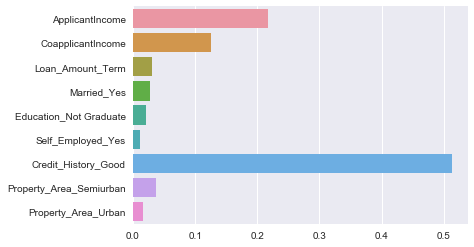

In [139]:
sns.barplot(x=final_random_forest_classifier.feature_importances_, y= X.columns)